In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] =  'black'
plt.rcParams['xtick.color'] =  'black'
plt.rcParams['ytick.color'] =  'black'
# Rozłożyć daty z 2 lat na zbiór testowy i treningowy, dodać cechy tygodnia, miesiąca, sezonu --> fastai tabular model
#cechy istnienia wyprzedaży czy nie.
df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df.columns = ['time', 'data', 'wyprzedaz']
df.head()

,time,data,wyprzedaz
0,2018-01-01,100.0,0
1,2018-01-02,94.0,0
2,2018-01-03,118.0,1
3,2018-01-04,114.0,1
4,2018-01-05,122.0,1


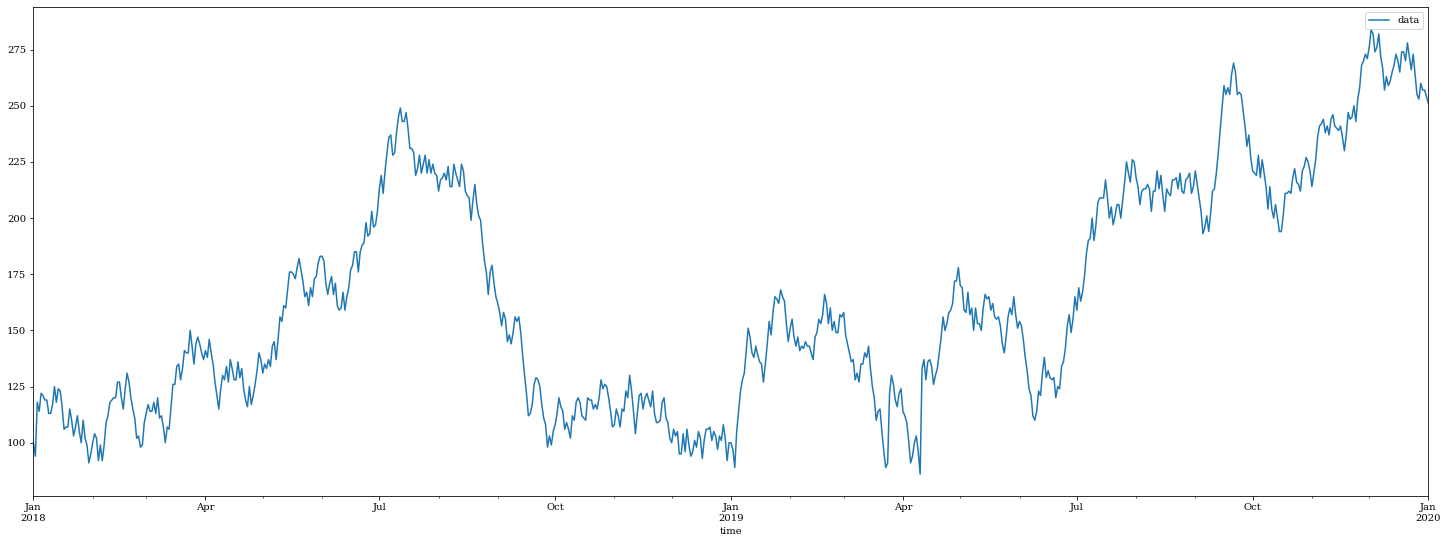

In [19]:
df.plot(x='time', y='data', figsize=(25, 9))

/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/marzi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


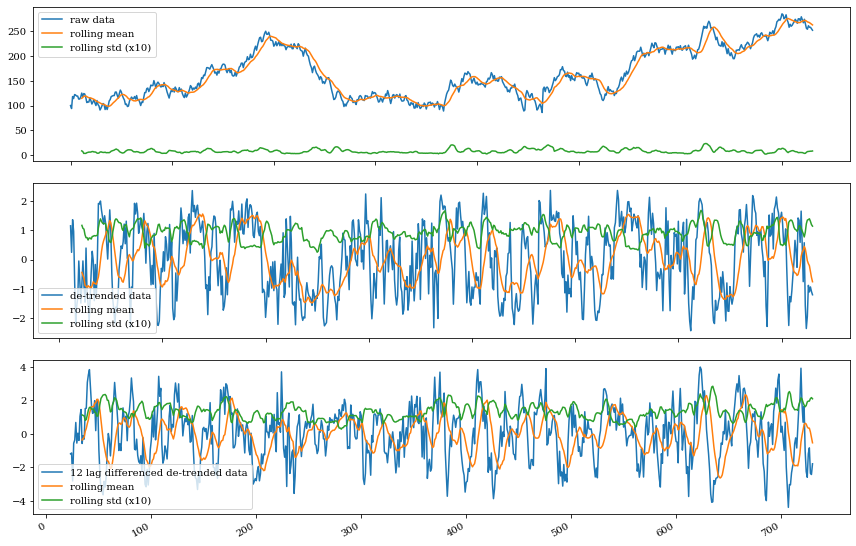

In [14]:
df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(df)

In [15]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

/home/marzi/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 > Is the data stationary ?
Test statistic = -1.547
P-value = 0.510
Critical values :
	1%: -3.4393396487377155 - The data is not stationary with 99% confidence
	5%: -2.865507363200066 - The data is not stationary with 95% confidence
	10%: -2.5688826684180897 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -9.669
P-value = 0.000
Critical values :
	1%: -3.439477677285233 - The data is  stationary with 99% confidence
	5%: -2.865568186630048 - The data is  stationary with 95% confidence
	10%: -2.5689150720653977 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -7.936
P-value = 0.000
Critical values :
	1%: -3.439890503006147 - The data is  stationary with 99% confidence
	5%: -2.865750085260771 - The data is  stationary with 95% confidence
	10%: -2.569011980884938 - The data is  stationary with 90% confidence


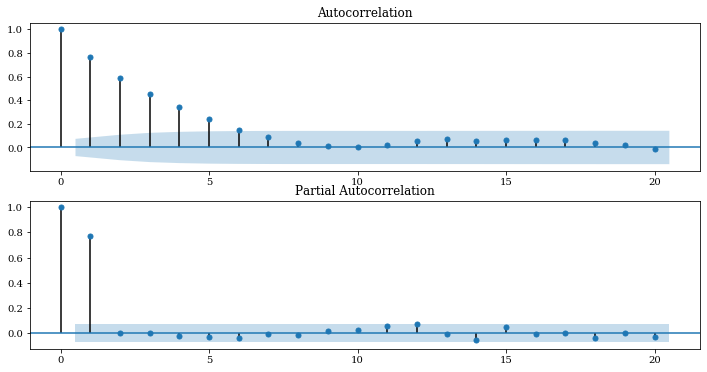

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)
#6 lag i 2 

In [20]:
from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(np.log(df.data), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.393
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/home/marzi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/marzi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [152]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
%matplotlib inline
plt.style.use('Solarize_Light2')

df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
ranges = [f'2020-02-0{i}' for i in range(1,8)]

def create_date_window(in_date, window_size):
    date_upper = pd.to_datetime(in_date) + pd.DateOffset(days=window_size)
    date_upper = date_upper.strftime('%Y-%m-%d')
    return date_upper

while True:
    df_new = pd.DataFrame([[0,0,0]], columns=['DATA', 'wyprzedaż', 'zamowienia'])
    df = df.append(df_new, ignore_index = True)
    df.iloc[df.shape[0]-1,0] = create_date_window(df.iloc[df.shape[0]-2,0], 1)
    if any(df.iloc[df.shape[0]-1,0] == r for r in ranges):
        df.iloc[df.shape[0]-1,1] = 1    
    if df.iloc[df.shape[0]-2,0] == '2020-03-01':
        break
        
df.tail()

,DATA,zamowienia,wyprzedaż
787,2020-02-27,0.0,0
788,2020-02-28,0.0,0
789,2020-02-29,0.0,0
790,2020-03-01,0.0,0
791,2020-03-02,0.0,0


In [75]:
df = df.iloc[:, 0:2]
df.columns = ['time', 'data']
df = df.set_index('time')
train = df.iloc[:732,0:2]
test = df.iloc[732:,0:2]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

train.head()

,data
time,
2018-01-01,100.0
2018-01-02,94.0
2018-01-03,118.0
2018-01-04,114.0
2018-01-05,122.0


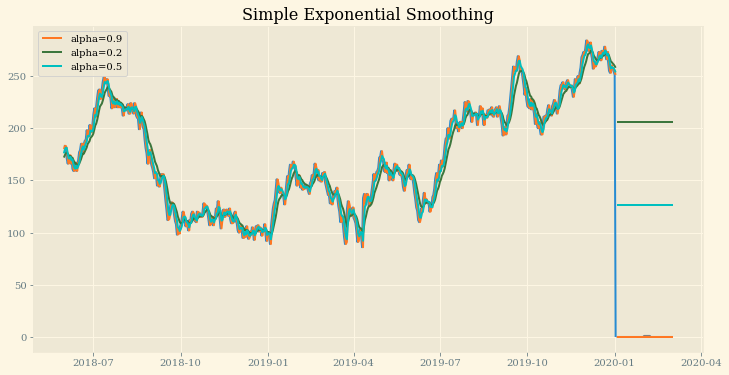

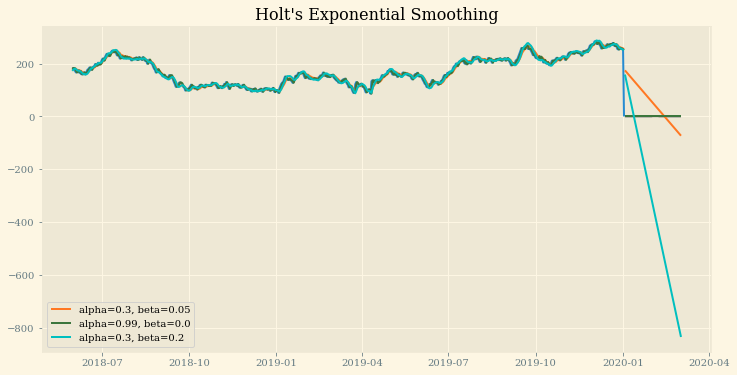

In [91]:
model = SimpleExpSmoothing(np.asarray(train['data']))
# model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(60)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(60)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(60)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
model = Holt(np.asarray(train['data']))
# model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(60)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(60)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(60)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [81]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from fbprophet import Prophet
import pandas as pd

In [143]:
df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df.columns = ['time', 'data', 'wyprzedaz']
df = df.iloc[:, 0:2]
dfs = df.copy()
dfs.columns = ['ds', 'y']

predictions_simple = []
errors_simple = []
predictions_holt = []
errors_holt = []
predictions_prop = []
errors_prop = []

for i in range(365, len(df)-1-60):
    train, test = df.iloc[:i,], df.iloc[i:i+60,]
    model = SimpleExpSmoothing(np.asarray(train['data']))
    fit1 = model.fit()
    pred1 = fit1.forecast(60)
#     predictions_simple.append(pred1[0])
    error = math.sqrt(mean_squared_error(test['data'].values,pred1))
    errors_simple.append(error)
    
    model = Holt(np.asarray(train['data']))
    fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
    pred2 = fit1.forecast(60)
#     predictions_holt.append(pred1[0])
    error = math.sqrt(mean_squared_error(test['data'].values,pred2))
    errors_holt.append(error)
    
    m = Prophet()
    train, test = dfs.iloc[:i,], dfs.iloc[i:i+60,]
    m.fit(train)
    future = m.make_future_dataframe(periods=60) 
    forecast = m.predict(future)
#     print(forecast[forecast.ds == test['ds'] ]['yhat'].values[0])
#     predictions_prop.append(forecast[forecast.ds == test['ds'] ]['yhat'].values[0])
    error = math.sqrt(mean_squared_error(test['y'].values, forecast[forecast.ds > train['ds'].iloc[-1] ]['yhat'].values))
    errors_prop.append(error)

    
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [202]:
df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df.columns = ['time', 'data', 'wyprzedaz']
df = df.iloc[:, 0:2]
dfs = df.copy()
dfs.columns = ['ds', 'y']
dfs.tail()

,ds,y
726,2019-12-28,260.0
727,2019-12-29,257.0
728,2019-12-30,257.0
729,2019-12-31,254.0
730,2020-01-01,251.0


In [205]:
m = Prophet()
m.fit(dfs)
future = m.make_future_dataframe(periods=60) 
forecast = m.predict(future)
#     print(forecast[forecast.ds == test['ds'] ]['yhat'].values[0])
#     predictions_prop.append(forecast[forecast.ds == test['ds'] ]['yhat'].values[0])
# error = math.sqrt(mean_squared_error(test['y'].values, forecast[forecast.ds > train['ds'].iloc[-1] ]['yhat'].values))
# errors_prop.append(error)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [198]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
724,2019-12-26,268.715013,239.852827,296.737720,260.002960,277.396816,0.099385,0.099385,0.099385,0.099385,0.099385,0.099385,0.0,0.0,0.0,268.814398
725,2019-12-27,269.239269,240.230345,298.867071,260.308717,278.168748,-0.101478,-0.101478,-0.101478,-0.101478,-0.101478,-0.101478,0.0,0.0,0.0,269.137791
726,2019-12-28,269.763524,238.732740,296.204819,260.543928,278.877322,-0.505851,-0.505851,-0.505851,-0.505851,-0.505851,-0.505851,0.0,0.0,0.0,269.257673
727,2019-12-29,270.287780,242.456898,300.279102,260.707482,279.682632,0.286709,0.286709,0.286709,0.286709,0.286709,0.286709,0.0,0.0,0.0,270.574488
728,2019-12-30,270.812035,241.064580,300.635433,260.816669,280.443497,-0.042371,-0.042371,-0.042371,-0.042371,-0.042371,-0.042371,0.0,0.0,0.0,270.769664


In [163]:
df.columns = ['time', 'data', 'wypr']
train, test = df.iloc[:730,0:2], df.iloc[730:790,0:2]
model = SimpleExpSmoothing(np.asarray(train['data']))
fit1 = model.fit()
pred1 = fit1.forecast(60)

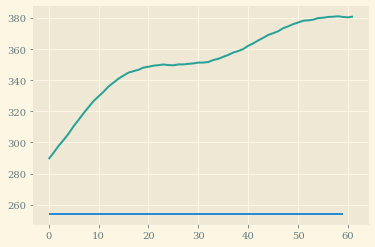

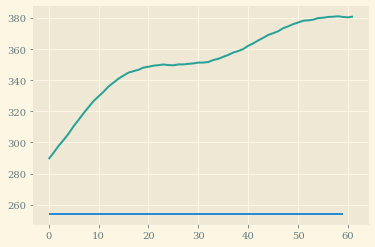

In [211]:
# df.plot(x='time', y='data')
plt.plot(pred1)
plt.plot(forecast[forecast.ds > '2019-12-30' ]['yhat'].values)

In [213]:
sum(pred1[0:31])

7876.528774991657

In [150]:
from sklearn import tree

df = pd.read_csv("predykcja.csv", sep=';')
df = df[-df.DATA.isna()]
df.DATA = pd.to_datetime(df['DATA'], format="%d.%m.%Y")
df.wyprzedaż = df.wyprzedaż.fillna(0).astype(int)
df.columns = ['time', 'data', 'wyprzedaz']
df['mean'] = df.data.shift(fill_value=100).rolling(window=60, min_periods=1).mean()
predictions_decisiontree = []
errors_decisiontree = []

for i in range(365, len(df)-1-60):
    train, test = df.iloc[:i,], df.iloc[i:i+60,]
          
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train[['mean', 'wyprzedaz']].values, train['data'].values)

    pred1 = clf.predict(test[['mean', 'wyprzedaz']].values)
#     predictions_decisiontree.append(pred1[0])
    error = math.sqrt(mean_squared_error(test['data'].values,pred1))
    errors_decisiontree.append(error)

In [151]:
print("Simple expo error:", np.mean(errors_simple))
print("Simple expo error:", np.mean(errors_holt))
print("Simple expo error:", np.mean(errors_prop))
print("Simple expo error:", np.mean(errors_decisiontree))

Simple expo error: 31.92516977579036
Simple expo error: 52.33343293043042
Simple expo error: 33.330373348266846
Simple expo error: 45.61295557239423


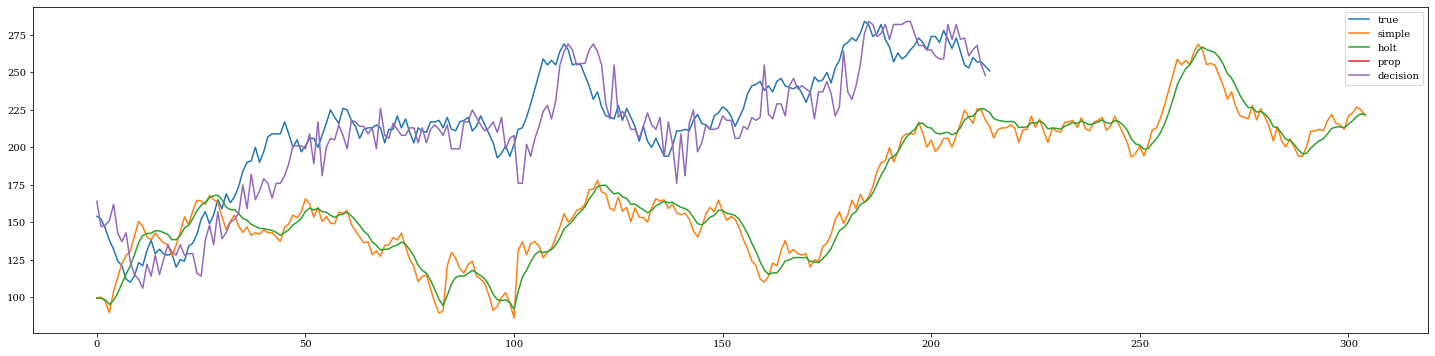

In [123]:
fig, ax = plt.subplots(figsize=(25, 6))
plt.plot(df.iloc[516:,1:2].values)
plt.plot(predictions_simple)
plt.plot(predictions_holt)
plt.plot(predictions_prop)
plt.plot(predictions_decisiontree)

plt.legend(['true', 'simple', 'holt', 'prop', 'decision'])
